In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout, MaxPooling2D, AveragePooling2D, Activation, Embedding, MaxPooling1D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

class CatBoostEvalMetricPearson(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        preds = np.array(approxes[0])
        target = np.array(target)

        return np.corrcoef(target, preds)[0, 1], 0.0

def pearson_metric(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    # normalizing stage - setting a 0 mean.
    y_true -= K.mean(y_true, axis=-1)
    y_pred -= K.mean(y_pred, axis=-1)
    # normalizing stage - setting a 1 variance
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    # final result
    pearson_correlation = K.sum(y_true * y_pred, axis=-1)
    return pearson_correlation


In [2]:
ter_fe = { "aa": 0.03, "uu": 0.03, "au": 0.38, "ua": 0.16, "cu": 0.55, "ag": -0.19, "ca": 0.08, "ug": -0.05, "gu": 0.55, "ac": -0.05, "ga": 0.39, "uc": -0.20, "cg": -0.10, "gg": -0.16, "cc": 0.0, "gc": -0.12 }
int_fe = { "aa": -0.87, "uu": -0.87, "au": -1.21, "ua": -1.12, "cu": -2.14, "ag": -2.14, "ca": -1.94, "ug": -1.94, "gu": -2.29, "ac": -2.29, "ga": -2.23, "uc": -2.23, "cg": -2.31, "gg": -3.18, "cc": -3.18, "gc": -3.34 }

# Takayuki Katoh, Tsutomu Suzuki, Specific residues at every third position of siRNA shape its efficient RNAi activity, Nucleic Acids Research, Volume 35, Issue 4, 15 February 2007, Page e27, https://doi.org/10.1093/nar/gkl1120
lin_coef = [
    {'a': -1.555, 'u': -3.155, 'g': 3.492, 'c': 3.136},
    {'a': -2.237, 'u': -1.856, 'g': 0.364, 'c': -0.067},
    {'a': 1.190, 'u': -0.341, 'g': -1.226, 'c': -0.808},
    {'a': -0.179, 'u': 0.070, 'g': -1.362, 'c': -0.136},
    {'a': -0.154, 'u': -2.258, 'g': -0.454, 'c': 0.698},
    {'a': 3.034, 'u': -1.407, 'g': 0.387, 'c': -4.081},
    {'a': 3.038, 'u': -1.440, 'g': 0.637, 'c': -2.676},
    {'a': 2.341, 'u': -2.697, 'g': -0.735, 'c': -0.317},
    {'a': -2.028, 'u': 2.113, 'g': -0.938, 'c': 1.935},
    {'a': -1.455, 'u': 2.521, 'g': -0.787, 'c': -0.126},
    {'a': -0.938, 'u': -0.136, 'g': 0.614, 'c': -1.119},
    {'a': 1.112, 'u': -1.519, 'g': -0.177, 'c': -1.279},
    {'a': 2.601, 'u': 0.200, 'g': -2.095, 'c': -1.296},
    {'a': 2.092, 'u': -2.258, 'g': 1.037, 'c': -1.388},
    {'a': 1.797, 'u': -1.356, 'g': 1.962, 'c': -1.801},
    {'a': 2.758, 'u': 2.128, 'g': -2.188, 'c': -1.491},
    {'a': 0.915, 'u': -1.295, 'g': -1.090, 'c': -1.119},
    {'a': 1.971, 'u': 2.482, 'g': -2.853, 'c': -0.530},
    {'a': 5.310, 'u': 1.354, 'g': -2.785, 'c': -2.627}, 
]

def antisense(r: str):
    l = [{'a':'u','g':'c','c':'g','u':'a'}[x] for x in list(r)[::-1]]
    return ''.join(l)

def takayuki2007(seq: str):
    return sum([lin_coef[i][seq[i]] for i in range(len(seq))])

In [14]:
df = pd.read_csv('mollu.csv', index_col=0)

for i in range(19):
    df[f'Base{i}'] = df['Sequence'].str[i]

for i in range(18):
    df[f'FE{i}'] = df['Sequence'].str[i:i+2].apply(lambda x: (ter_fe if i == 0 or i == 17 else int_fe)[x])

df['FE_total'] = df[[f'FE{i}' for i in range(18)]].sum(axis=1)
df['FE_total_alpha'] = df[[f'FE{i}' for i in range(0, 18, 2)]].sum(axis=1)
df['FE_total_beta'] = df[[f'FE{i}' for i in range(1, 18, 2)]].sum(axis=1)
df['FE_5_end'] = df[[f'FE{i}' for i in (0, 2, 4)]].sum(axis=1)
df['FE_3_end'] = df[[f'FE{i}' for i in (13, 15, 17)]].sum(axis=1)
df['FE_53_diff'] = df['FE_5_end'] - df['FE_3_end']

# df['Takayuki2007'] = df['Sequence'].apply(takayuki2007)

nt1 = ['a', 'g', 'c', 'u']
nt2 = []
nt3 = []
for i in nt1:
    for j in nt1:
        nt2.append(f'{i}{j}')

for i in nt1:
    for j in nt1:
        for k in nt1:
            nt3.append(f'{i}{j}{k}')

nts = nt1 + nt2 + nt3
for nt in nts:
    df[f'{nt.upper()}_count'] = df['Sequence'].str.count(nt)

df['CNN_result'] = np.zeros(df.shape[0])

In [15]:
df

,Sequence,Activity,Base0,Base1,Base2,Base3,Base4,Base5,Base6,Base7,...,UGU_count,UCA_count,UCG_count,UCC_count,UCU_count,UUA_count,UUG_count,UUC_count,UUU_count,CNN_result
0,cgucccguaguagucgucg,0.627,c,g,u,c,c,c,g,u,...,0,0,2,1,0,0,0,0,0,0.0
1,cccguaguagucgucguag,0.690,c,c,c,g,u,a,g,u,...,0,0,2,0,0,0,0,0,0,0.0
2,guagucgucguagaagagg,0.827,g,u,a,g,u,c,g,u,...,0,0,2,0,0,0,0,0,0,0.0
3,uagucgucguagaagaggu,0.893,u,a,g,u,c,g,u,c,...,0,0,2,0,0,0,0,0,0,0.0
4,gucguagaagaggucugag,0.372,g,u,c,g,u,a,g,a,...,0,0,1,0,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,uucauauacuguuccagcu,0.975,u,u,c,a,u,a,u,a,...,1,1,0,1,0,0,0,2,0,0.0
1364,uauacuguuccagcugcuc,0.852,u,a,u,a,c,u,g,u,...,1,0,0,1,0,0,0,1,0,0.0
1365,acuguuccagcugcuccau,0.845,a,c,u,g,u,u,c,c,...,1,0,0,2,0,0,0,1,0,0.0
1366,ccagcugcuccauggaugg,0.807,c,c,a,g,c,u,g,c,...,0,0,0,1,0,0,0,0,0,0.0


In [16]:
def cnn_train(df, train_indices, val_indices, pad=11):
    def onehot_encode(seq: str):
        dt = {
            "a": [[1], [0], [0], [0]],
            "g": [[0], [1], [0], [0]],
            "c": [[0], [0], [1], [0]],
            "u": [[0], [0], [0], [1]],
        }

        res = [[[0]] * 4] * pad + [dt[b.lower()] for b in seq] + [[[0]] * 4] * pad
        return res

    X_c = np.array(df['Sequence'].apply(onehot_encode).tolist())
    y_c = df['Activity'].to_numpy().reshape(-1, 1)

    X_train_c = X_c[train_indices]
    X_val_c = X_c[val_indices]
    y_train_c = y_c[train_indices]
    y_val_c = y_c[val_indices]

    def create_cnn(input_shape):
        def create_filter(k: int):
            model = keras.Sequential([
                Conv2D(2, kernel_size=(k, 4), activation='relu'),
                Flatten(),
                Dense(4, activation='relu')
            ])

            return model

        inp = Input(shape=input_shape)
        con = Concatenate()([create_filter(i)(inp) for i in range(4, 20)])
        den1 = Dense(24, activation='relu')(con)
        den2 = Dense(1, activation='sigmoid')(den1)
        model = keras.Model(inputs=[inp], outputs=den2)

        model.compile(loss='mse', optimizer='adam', metrics=[pearson_metric])
        
        return model

    cnn = create_cnn(X_c.shape[1:])

    earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
    cnn.fit(X_train_c, y_train_c, validation_data=(X_val_c, y_val_c), epochs=100, callbacks=[earlystopping])

    df.loc[:, 'CNN_result'].iloc[val_indices] = cnn.predict(X_val_c).flatten()

    return df, cnn


def cb_train(df, train_indices, val_indices, cnn=True, plot=False):
    base_columns = [f'Base{i}' for i in range(19)]
    fe_columns = [f'FE{i}' for i in range(18)] + ['FE_total', 'FE_total_alpha', 'FE_total_beta', 'FE_53_diff']
    nt_columns = [f'{nt.upper()}_count' for nt in nts]
    other_columns = ['CNN_result'] if cnn else []
    cat_columns = base_columns

    y = df[['Activity']]
    X = df[base_columns + fe_columns + nt_columns + other_columns]
    # X = df[important_features]
    
    X_train = X.iloc[train_indices].copy()
    X_val = X.iloc[val_indices].copy()
    
    y_train = y.iloc[train_indices].copy()
    y_val = y.iloc[val_indices].copy()
    
    train_dataset = cb.Pool(X_train, y_train, cat_features=cat_columns)
    val_dataset = cb.Pool(X_val, y_val, cat_features=cat_columns)

    params = {
        'loss_function': 'RMSE',
        'eval_metric': CatBoostEvalMetricPearson(),
        'early_stopping_rounds': 300,
        'iterations': 3000,
        'silent': True
    }

    model = cb.CatBoostRegressor(**params)

    model.fit(train_dataset, eval_set=val_dataset, use_best_model=True, plot=plot)

    df['CB_result'] = model.predict(X)

    return df, model

def ensemble_train(df, train_indices, val_indices, plot=False):
    X = df[['CNN_result', 'CB_result']]
    y = df['Activity']

    X_train = X.iloc[train_indices].copy()
    X_val = X.iloc[val_indices].copy()

    y_train = y.iloc[train_indices].copy()
    y_val = y.iloc[val_indices].copy()

    train_dataset = cb.Pool(X_train, y_train)
    val_dataset = cb.Pool(X_val, y_val)

    params = {
        'loss_function': 'RMSE',
        'eval_metric': CatBoostEvalMetricPearson(),
        'early_stopping_rounds': 300,
        'iterations': 3000,
        'silent': True
    }

    model = cb.CatBoostRegressor(**params)
    model.fit(train_dataset, eval_set=val_dataset, use_best_model=True, plot=plot)

    return model

def ensemble_evaluate(model_e, df, test_indices):
    X = df[['CNN_result', 'CB_result']]
    y = df['Activity']

    X_test = X.iloc[test_indices].copy()
    y_test = y.iloc[test_indices].copy()
    
    return np.corrcoef(model_e.predict(X_test), y_test.to_numpy().flatten())[0, 1]

In [17]:
SEED = 42
train_indices, test_indices = train_test_split(np.arange(df.shape[0]), test_size=0.1, random_state=SEED)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1111111111111, random_state=SEED)

In [18]:
kf = KFold(2, random_state=42, shuffle=True)
models = []

for kf_train_indices, kf_val_indices in kf.split(train_indices):
    df, model = cnn_train(df, train_indices[kf_train_indices], train_indices[kf_val_indices])
    models.append(model)

Epoch 1/100
18/18 [==============================] - 17s 806ms/step - loss: 0.0907 - pearson_metric: -0.0286 - val_loss: 0.0330 - val_pearson_metric: 0.1936
Epoch 2/100
18/18 [==============================] - 14s 765ms/step - loss: 0.0396 - pearson_metric: 0.0862 - val_loss: 0.0339 - val_pearson_metric: 0.2910
Epoch 3/100
18/18 [==============================] - 14s 807ms/step - loss: 0.0363 - pearson_metric: 0.3201 - val_loss: 0.0304 - val_pearson_metric: 0.3524
Epoch 4/100
18/18 [==============================] - 14s 772ms/step - loss: 0.0341 - pearson_metric: 0.4320 - val_loss: 0.0296 - val_pearson_metric: 0.3907
Epoch 5/100
18/18 [==============================] - 15s 843ms/step - loss: 0.0331 - pearson_metric: 0.5373 - val_loss: 0.0286 - val_pearson_metric: 0.4258
Epoch 6/100
18/18 [==============================] - 14s 792ms/step - loss: 0.0269 - pearson_metric: 0.5875 - val_loss: 0.0274 - val_pearson_metric: 0.4497
Epoch 7/100
18/18 [==============================] - 15s 807ms/

/tmp/ipykernel_21400/2316629312.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'CNN_result'].iloc[val_indices] = cnn.predict(X_val_c).flatten()


Epoch 1/100
18/18 [==============================] - 16s 768ms/step - loss: 0.0421 - pearson_metric: -0.1036 - val_loss: 0.0413 - val_pearson_metric: -0.0078
Epoch 2/100
18/18 [==============================] - 14s 772ms/step - loss: 0.0306 - pearson_metric: 0.1965 - val_loss: 0.0388 - val_pearson_metric: 0.1884
Epoch 3/100
18/18 [==============================] - 15s 805ms/step - loss: 0.0317 - pearson_metric: 0.4260 - val_loss: 0.0358 - val_pearson_metric: 0.3314
Epoch 4/100
18/18 [==============================] - 13s 739ms/step - loss: 0.0246 - pearson_metric: 0.5415 - val_loss: 0.0334 - val_pearson_metric: 0.4156
Epoch 5/100
18/18 [==============================] - 13s 719ms/step - loss: 0.0236 - pearson_metric: 0.6152 - val_loss: 0.0314 - val_pearson_metric: 0.4785
Epoch 6/100
18/18 [==============================] - 15s 827ms/step - loss: 0.0201 - pearson_metric: 0.6600 - val_loss: 0.0290 - val_pearson_metric: 0.5219
Epoch 7/100
18/18 [==============================] - 14s 788ms

In [19]:
df, model_b = cb_train(df, train_indices, val_indices, cnn=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/hamerin/anaconda3/lib/python3.8/site-packages/catboost/core.py:1428: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(float64, 1d, C))
 
There are 4 candidate implementations:
   - Of which 4 did not match due to:
   Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
     With argument(s): '(array(float64, 1d, C))':
    Rejected as the implementation raised a specific error:
      TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    No implementation of function Function(<intrinsic stub>) found for signature:
     
     >>> stub(array(float64, 1d, C))
     
    There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Intrinsic in function 'stub': File: numba/core/overload_glue.py: 

In [20]:
model_b.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,CNN_result,13.716540
1,Base0,13.540996
2,FE17,4.495192
3,FE_total_beta,3.235648
4,FE_total,2.564847
5,Base1,2.266234
6,FE_total_alpha,1.964982
7,FE0,1.915745
8,GGG_count,1.871002
9,Base18,1.725415


In [21]:
df_display_nocnn = df.copy()

In [22]:
dft = df_display_nocnn.iloc[test_indices]
dft[['CB_result', 'Activity']].corr()

,CB_result,Activity
CB_result,1.000000,0.658301
Activity,0.658301,1.000000


Text(0.12, 0.72, 'R = 0.671')

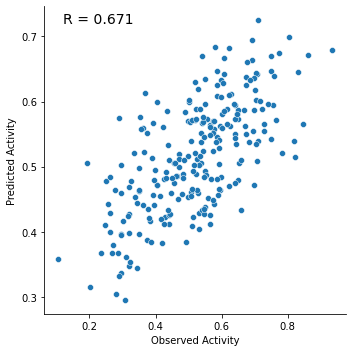

In [1178]:
dft = df_display_nocnn.iloc[test_indices]
sns.relplot(data=dft[['CB_result', 'Activity']], x='Activity', y='CB_result')
plt.xlabel('Observed Activity')
plt.ylabel('Predicted Activity')
plt.text(0.12, 0.72, 'R = 0.671', fontsize=14)

In [1141]:
df_display_cnn = df.copy()

In [1142]:
dft = df_display_cnn.iloc[test_indices]
dft[['CB_result', 'Activity']].corr()

,CB_result,Activity
CB_result,1.00000,0.68905
Activity,0.68905,1.00000


Text(0.12, 0.72, 'R = 0.689')

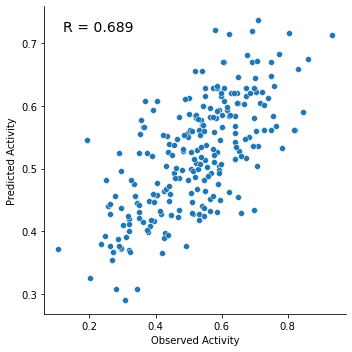

In [1177]:
dft = df_display_cnn.iloc[test_indices]
sns.relplot(data=dft[['CB_result', 'Activity']], x='Activity', y='CB_result')
plt.xlabel('Observed Activity')
plt.ylabel('Predicted Activity')
plt.text(0.12, 0.72, 'R = 0.689', fontsize=14)

In [1025]:
from sklearn.linear_model import LinearRegression

indices = np.concatenate((train_indices, val_indices))
X = df.iloc[test_indices][['CNN_result', 'CB_result']].to_numpy()
y = df.iloc[test_indices]['Activity'].to_numpy()

reg = LinearRegression(fit_intercept=False).fit(X, y)
reg.coef_

array([0.74243069, 0.27943696])

In [1026]:
df['Stacked_result'] = reg.predict(df[['CNN_result', 'CB_result']].to_numpy())

In [1027]:
df.iloc[test_indices][['Stacked_result', 'CNN_result', 'CB_result', 'Activity']].corr()

,Stacked_result,CNN_result,CB_result,Activity
Stacked_result,1.000000,0.991285,0.931487,0.679124
CNN_result,0.991285,1.000000,0.875449,0.670806
CB_result,0.931487,0.875449,1.000000,0.639220
Activity,0.679124,0.670806,0.639220,1.000000


In [882]:
X = df[['CNN_result', 'CB_result']]
y = df['Activity']

X_train = X.iloc[train_indices].copy()
X_val = X.iloc[val_indices].copy()
X_test = X.iloc[test_indices].copy()

y_train = y.iloc[train_indices].copy()
y_val = y.iloc[val_indices].copy()
y_test = y.iloc[test_indices].copy()

train_dataset = cb.Pool(X_train, y_train)
val_dataset = cb.Pool(X_val, y_val)

params = {
    'loss_function': 'RMSE',
    'eval_metric': CatBoostEvalMetricPearson(),
    'early_stopping_rounds': 300,
    'iterations': 3000,
    'silent': True
}

f_model = cb.CatBoostRegressor(**params)

f_model.fit(train_dataset, eval_set=val_dataset, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/hamerin/anaconda3/lib/python3.8/site-packages/catboost/core.py:1428: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(float64, 1d, C))
 
There are 4 candidate implementations:
      - Of which 4 did not match due to:
      Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
        With argument(s): '(array(float64, 1d, C))':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<intrinsic stub>) found for signature:
        
        >>> stub(array(float64, 1d, C))
        
       There are 2 candidate implementations:
         - Of which 2 did not match due to:
         Intrinsic in function 'stub':

In [885]:
np.corrcoef(f_model.predict(X_test), y_test)

array([[1.        , 0.70309487],
       [0.70309487, 1.        ]])

In [869]:
fi = model.get_feature_importance(prettified=True)
fi.head(30)

,Feature Id,Importances
0,Base0,16.690781
1,FE17,5.652823
2,FE_total_beta,3.488061
3,Takayuki2007,3.395898
4,FE0,3.102248
5,Base17,2.859389
6,FE_total,2.452974
7,FE_53_diff,2.296562
8,FE_total_alpha,2.202475
9,Base18,2.161616


In [828]:
%%capture

kf = KFold(10, random_state=42, shuffle=True)

pcc = []

for train_indices, test_indices in kf.split(df):
    train_indices, val_indices = train_test_split(train_indices, test_size=0.1111111111111)
    train_indices_c, train_indices_b = train_test_split(train_indices, test_size=0.7)

    df, model_c = cnn_train(df, train_indices, val_indices)

In [829]:
pd.Series(pcc).describe()

count    10.000000
mean      0.643661
std       0.036258
min       0.588764
25%       0.620902
50%       0.655985
75%       0.666996
max       0.698102
dtype: float64

In [700]:
pd.Series(pcc).describe()

count    10.000000
mean      0.644968
std       0.023923
min       0.595533
25%       0.629429
50%       0.652784
75%       0.663389
max       0.669862
dtype: float64

In [691]:
pd.Series(pcc).describe()

count    10.000000
mean      0.644852
std       0.022977
min       0.607210
25%       0.625752
50%       0.648255
75%       0.663971
max       0.676299
dtype: float64

In [523]:
important_features = model.get_feature_importance(prettified=True).head(30)['Feature Id']
important_cat_features = important_features[important_features.str.startswith('Base')]

In [1155]:
model_b.save_model('cat_f_0.6891')

In [1157]:
models[0].save('cnn_f_0')
models[1].save('cnn_f_1')

2022-07-10 15:41:40.364973: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_f_0/assets
INFO:tensorflow:Assets written to: cnn_f_1/assets


In [1158]:
df_display_cnn.to_csv('cnn_f.csv')
df_display_nocnn.to_csv('nocnn_f.csv')

In [1159]:
df_display_cnn

,Sequence,Activity,Base0,Base1,Base2,Base3,Base4,Base5,Base6,Base7,...,UCG_count,UCC_count,UCU_count,UUA_count,UUG_count,UUC_count,UUU_count,CNN_result,CB_result,Stacked_result
0,cuaauauguuaauugauuu,0.344519,c,u,a,a,u,a,u,g,...,0,0,0,1,1,0,1,0.540080,0.397956,0.481176
1,aauauguuaauugauuuau,0.286353,a,a,u,a,u,g,u,u,...,0,0,0,2,1,0,1,0.548740,0.427070,0.571501
2,gauuuauacaauuccuuuc,0.383296,g,a,u,u,u,a,u,a,...,0,1,0,1,0,2,2,0.621747,0.459761,0.585357
3,caauuccuuucaauuuuau,0.271439,c,a,a,u,u,c,c,u,...,0,1,0,1,0,2,2,0.482836,0.308435,0.427226
4,cagaccaaaauuaaauaag,0.389262,c,a,g,a,c,c,a,a,...,0,0,0,1,0,0,0,0.500321,0.400650,0.546197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,aaaacccacccuacaaagu,0.666667,a,a,a,a,c,c,c,a,...,0,0,0,0,0,0,0,0.557676,0.616814,0.583768
2427,gaugaucagaagcugaacu,0.539150,g,a,u,g,a,u,c,a,...,0,0,0,0,0,0,0,0.493060,0.526075,0.512281
2428,aucagaagcugaacuacuc,0.684564,a,u,c,a,g,a,a,g,...,0,0,0,0,0,0,0,0.596722,0.654921,0.608683
2429,gaagcugaacuacucgguu,0.462342,g,a,a,g,c,u,g,a,...,1,0,0,0,0,0,0,0.493239,0.500115,0.494744
